__Reading data into memory and preprocessing__

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch neural network module
import torch.nn as nn

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# to reload modules
#import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 20
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE
        }
mp.rc('font', **font)
#mp.rc('xtick', labelsize='x-small')
#mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

### Load Higgs boson data into memory


In [4]:
train_data = pd.read_csv('datasets/hzz_vbf_ggf_train.csv') 
test_data  = pd.read_csv('datasets/hzz_vbf_ggf_test.csv')
print(len(train_data))
print(len(test_data))
train_data[:5]

50000
10000


,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,90.29,14.06,215.80,-0.1829,86.08,0.3362,324.5,0.4905,0.0
1,86.57,37.24,217.80,0.3579,310.20,2.8900,219.9,0.1691,0.0
2,97.37,13.46,138.90,-0.8100,220.40,2.9030,106.3,0.4296,0.0
3,91.96,18.97,54.89,-2.6840,583.50,5.0130,101.6,1.7580,1.0
4,91.45,12.06,187.80,-0.5866,55.98,0.3771,220.2,0.6852,1.0


### Plot data

In [5]:
def plotData(data, 
             xmin=0, xmax=8, 
             ymin=0, ymax=1600, 
             N=1000, ftsize=FONTSIZE):
    
    # set size of figure
    plt.figure(figsize=(6, 6));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=ftsize)
    
    # split into sig and bkg for the purposes of plotting
    sig = data[data.target > 0.5][:N]
    bkg = data[data.target < 0.5][:N]

    plt.scatter(sig.detajj, sig.massjj, marker='o',
                s=50, c='red', alpha=0.3, label='VBF')
    plt.legend(loc='upper left') # activate legend
    
    plt.scatter(bkg.detajj, bkg.massjj, marker='*',
                s=100, c='blue',  alpha=0.3, label='ggF')
    plt.legend(loc='upper left') # activate legend
    
    plt.savefig('higgs_vbf_ggf.png')
    plt.show()

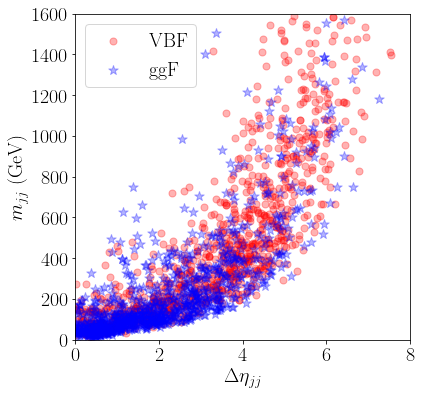

In [6]:
plotData(train_data)

### Prepare data for training/testing

In [7]:
def standardize_data(train_data, test_data, inputs):
    scaler  = StandardScaler()
    scaler.fit(train_data[inputs])
    
    train_x = scaler.transform(train_data[inputs])
    train_y = train_data['target']
        
    test_x  = scaler.transform(test_data[inputs])
    test_y  = test_data['target']

    return (train_y, train_x, test_y, test_x, scaler)

In [11]:
inputs = ['detajj', 'massjj']
processed_data = standardize_data(train_data, test_data, inputs)
train_y, train_x, test_y, test_x, scaler = processed_data

5000.0